# General linear model on fMRI data



## First level analysis

Analysis performed on a level of single subject (individual).

In [2]:
# Import libraries
! pip install nistats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nistats.first_level_model import FirstLevelModel
from nistats.reporting import plot_design_matrix
from nistats.reporting import plot_contrast_matrix
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
from nistats.thresholding import map_threshold
from nistats.reporting import get_clusters_table

C:\Users\Iga\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  import sys
C:\Users\Iga\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# Load a lable with events
events_path = "../data/fMRI_BIDS_rhymejudgment/sub-01/func/sub-01_task-rhymejudgment_events.tsv"
events = pd.read_csv(events_path, sep="\t")
events.head()

onset  duration trial_type
0  20.001       2.0       word
1  22.501       2.0       word
2  25.001       2.0       word
3  27.501       2.0       word
4  30.001       2.0       word

In [4]:
# Load preprocessed fMRI image
fmri_img = "../data/fMRI_BIDS_rhymejudgment/derivatives/fmriprep/sub-01/func/sub-01_task-rhymejudgment_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
confounds_path = "../data/fMRI_BIDS_rhymejudgment/derivatives/fmriprep/sub-01/func/sub-01_task-rhymejudgment_desc-confounds_regressors.tsv"

#confounds- regressors 

confounds = pd.read_csv(confounds_path, sep="\t")
motion = confounds[["trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z"]]

In [ ]:
#fitting model to the data 

t_r = 2 #time of repetition

first_level_model = FirstLevelModel(t_r, 
                                    hrf_model='spm', #shape of a hemodynamic delay function
                                    high_pass=.01,
                                    smoothing_fwhm=6) #initializing an object (model) with specification

first_level_model = first_level_model.fit(fmri_img, events=events) 

In [10]:
design_matrix = first_level_model.design_matrices_[0]

# Print head of the dataframe
design_matrix.head()

AttributeError: 'FirstLevelModel' object has no attribute 'design_matrices_'

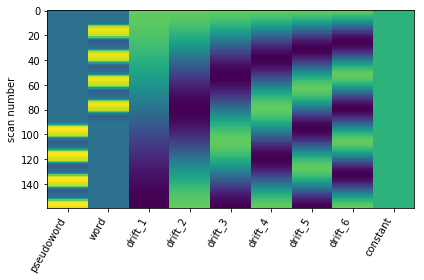

In [69]:
# Plot design matrix
plot_design_matrix(design_matrix)

In [29]:
# Print timeseries of task-HRF data

plt.plot(design_matrix["pseudoword"])
plt.plot(design_matirx["word"])
plt.legend(design_matrix.columns[0:2])
plt.show()

In [70]:
# Create conditions
conditions = {'pseudoword': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0]), 
              'word': np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

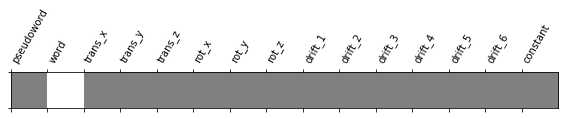

In [46]:
# Create contrasts
word_minus_pseudoword = conditions['word'] - conditions['pseudoword']
word_effect = conditions['word']

# Plot contrast matrix
plot_contrast_matrix(word_effect, design_matrix=design_matrix)
plot_contrast_matrix(word_minus_pseudoword, design_matrix=design_matrix)

In [ ]:
print(word_minus_pseudoword)

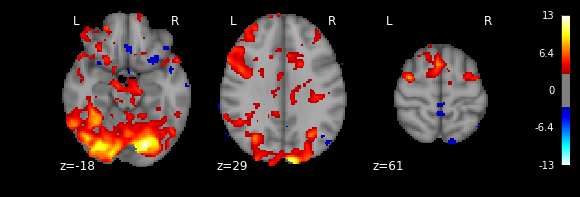

In [61]:
# Calculate statistic test for selected contrast
z_map = first_level_model.compute_contrast(word_effect,
                                  output_type='z_score')
plot_stat_map(z_map, threshold=3,
              display_mode='z', cut_coords=3, black_bg=True)
plt.show()

Uncorrected p<0.001 threshold: 5.048


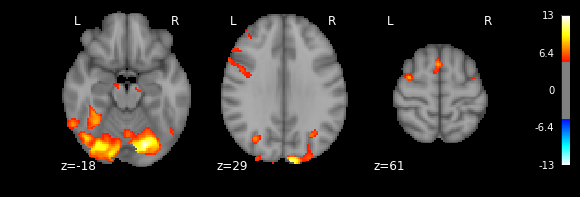

In [65]:
# Threshold z-matrices to correct for multiple comparisons
_, threshold = map_threshold(z_map, alpha=.05, height_control='bonferroni')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True)
plt.show()

In [63]:
# Get cluster table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
print(table)

   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1  19.5 -76.5 -18.5  12.840794              73224
1          1a   7.5 -92.5  29.5  10.993894                   
2          1b   9.5 -82.5 -16.5  10.538513                   
3          1c -26.5 -78.5 -20.5  10.455395                   
4           2 -40.5  -2.5  37.5   9.127752              11368
5          2a -52.5   1.5  47.5   9.019779                   
6          2b -52.5  21.5  23.5   8.647285                   
7          2c -32.5  -6.5  47.5   8.313163                   
8           3  -8.5   9.5  51.5   8.362639               5688
9          3a  -2.5  11.5  59.5   7.936133                   
10         3b  -6.5  19.5  47.5   7.511798                   
11         3c   7.5  11.5  51.5   7.498224                   
12          4 -30.5 -72.5  37.5   8.274424               2096
13         4a -32.5 -70.5  25.5   7.277828                   
14         4b -26.5 -74.5  19.5   5.774544                   
15      

In [ ]:
# Repeat everything with motion as nuisance regressors.

